<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/GauGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 679 kB 8.2 MB/s 


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow_addons.layers import InstanceNormalization

import numpy as np
import matplotlib.pyplot as plt
import os
import random

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget  -P ./datasets https://github.com/PacktPublishing/Hands-On-Image-Generation-with-TensorFlow-2.0/raw/master/Chapter06/facades_data.zip
!unzip /content/datasets/facades_data.zip

In [4]:
from glob import glob 
from PIL import Image
from sklearn.model_selection import train_test_split
PATH = './facades_data/'

files = glob(PATH+'*.jpg')
train_files, val_files = train_test_split(files, test_size=0.2)

In [5]:
BATCH_SIZE = 4
BUFFER_SIZE = 400
IMG_HEIGHT = IMG_WIDTH = 256
N_CLASS = 12

def load(image_file):
    def random_crop(images, crop_size=(IMG_HEIGHT, IMG_WIDTH)):
        image_shape = np.array(images[0].shape[:2])
        crop_size = np.array(crop_size)
        margins = image_shape - crop_size
        y1 = random.randint(0, margins[0])
        x1 = random.randint(0, margins[1])
        y2 = y1 + crop_size[0]
        x2 = x1 + crop_size[1]

        cropped_images = []
        for img in images:
            cropped_images.append(img[y1:y2, x1:x2])

        return cropped_images

    def load_data(image_file):
        jpg_file = image_file.numpy().decode("utf-8")
        
        bmp_file = jpg_file.replace('.jpg','.bmp')
        png_file = jpg_file.replace('.jpg','.png')
        
        image = np.array(Image.open(jpg_file))/127.5 - 1
        map = np.array(Image.open(png_file))/127.5 - 1
        labels = np.array(Image.open(bmp_file), dtype=np.uint8)
        
        image, map, labels = random_crop([image, map, labels])
        
        h, w, _ = image.shape
        n_class = N_CLASS
        mask = np.zeros((h, w, n_class), dtype=np.float32)
        for i in range(n_class):
            mask[labels==i, i] = 1
        
        return map, image, mask

    [map, image, label] = tf.py_function(load_data, [image_file], 
                                          [tf.float32, tf.float32, tf.float32])
    
    
    return map, image, label

train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices(val_files)
test_dataset = test_dataset.map(load)
test_dataset = test_dataset.batch(1, drop_remainder=True).repeat()

In [6]:
class SPADE(layers.Layer):

    def __init__(self, filters, epsilon=1e-5):
        super(SPADE, self).__init__()
        self.epsilon = epsilon
        self.conv = layers.Conv2D(128, 3, padding='same', activation = 'relu')
        self.conv_gamma = layers.Conv2D(filters, 3, padding='same')
        self.conv_beta = layers.Conv2D(filters, 3, padding='same')

    def build(self, input_shape):
        self.resize_input = input_shape[1:3]
    
    def call(self, input_tensor, raw_mask):
        mask = tf.image.resize(raw_mask, self.resize_input)

        x = self.conv(mask)
        gamma = self.conv_gamma(x)
        beta = self.conv_beta(x)

        mean, var = tf.nn.moments(input_tensor, axes=(0, 1, 2), keepdims = True)
        std = tf.sqrt(var + self.epsilon)
        normalized = (input_tensor - mean) / var

        return gamma * normalized + beta

In [7]:
class Resblock(layers.Layer):

    def __init__(self, filters):
        super(Resblock, self).__init__()
        self.filters = filters

    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.spade1 = SPADE(input_filter)
        self.spade2 = SPADE(self.filters)
        self.conv1 = layers.Conv2D(self.filters, 3, padding='same')
        self.conv2 = layers.Conv2D(self.filters, 3, padding='same')
        self.learned_skip = False

        if self.filters != input_filter:
            self.learned_skip = True
            self.spade3 = SPADE(input_filter)
            self.conv3 = layers.Conv2D(self.filters, 3, padding='same')
    
    def call(self, input_tensor, mask):

        x = self.spade1(input_tensor, mask)
        x = self.conv1(tf.nn.leaky_relu(x, 0.2))

        x = self.spade2(x, mask)
        x = self.conv2(tf.nn.leaky_relu(x, 0.2))

        if self.learned_skip:
            skip = self.spade3(input_tensor, mask)
            skip = self.conv3(tf.nn.leaky_relu(skip, 0.2))
        else:
            skip = input_tensor
        
        output = skip + x
        
        return output


In [8]:
class GaussianSampling(layers.Layer):

    def __init__(self, batch_size, z_dim):
        super(GaussianSampling, self).__init__()

        self.z_dim = z_dim
        self.batch_size = batch_size
    
    def call(self, inputs):
        mean, logvar = inputs
        epsilon = tf.random.normal(shape=(self.batch_size, self.z_dim), mean=0., stddev = 1.)
        return mean + tf.exp(logvar * 0.5) * epsilon

In [9]:
def downsample(channels, kernels, strides=2, norm=True, activation=True, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()
    block = tf.keras.Sequential()
    block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

    if norm:
        block.add(InstanceNormalization())              
    if activation:
        block.add(layers.LeakyReLU(0.2)) 
    if dropout:
        block.add(layers.Dropout(0.5))

    return block

In [10]:
def build_generator(image_shape, mask_shape, z_dim):
    DIM = 64

    z = layers.Input(shape=(z_dim,))
    mask = layers.Input(shape=mask_shape)

    x = layers.Dense(4 * 4 * 1024)(z)
    x = layers.Reshape((4, 4, 1024))(x)

    x = Resblock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)

    x = Resblock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)

    x = Resblock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)

    x = Resblock(filters=512)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)

    x = Resblock(filters=256)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)

    x = Resblock(filters=128)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)

    x = tf.nn.leaky_relu(x, 0.2)
    output_image = tanh(layers.Conv2D(3, 4, padding='same')(x))

    return Model([z, mask], output_image, name='generator')

In [11]:
def build_discriminator(image_shape):
    DIM = 64
    model = tf.keras.Sequential(name='discriminators') 
    input_image_A = layers.Input(shape=image_shape, name='discriminator_image_A')
    input_image_B = layers.Input(shape=image_shape, name='discriminator_image_B')
        
    x = layers.Concatenate()([input_image_A, input_image_B])

    x1 = downsample(DIM, 4, norm=False)(x) # 128
    x2 = downsample(2*DIM, 4)(x1) # 64
    x3 = downsample(4*DIM, 4)(x2) # 32
    x4 = downsample(8*DIM, 4, strides=1)(x3) # 29
    x5 = layers.Conv2D(1, 4)(x4)

    outputs = [x1, x2, x3, x4, x5]
    return Model([input_image_A, input_image_B], outputs)

In [12]:
def build_encoder(image_shape, z_dim = 256):
    DIM = 64
    input_image = layers.Input(shape=image_shape)
    x = downsample(DIM, 3, norm=False)(input_image) 
    x = downsample(2*DIM, 3)(x) 
    x = downsample(4*DIM, 3)(x) 
    x = downsample(8*DIM, 3)(x) 
    x = downsample(8*DIM, 3)(x) 
    x = layers.Flatten()(x)
    mean = layers.Dense(z_dim, name='mean')(x)
    logvar = layers.Dense(z_dim, name='logvar')(x)
    return Model(input_image, [mean, logvar], name='encoder')

In [13]:
def build_vgg():
    encoder_layers = ['block1_conv1',
                               'block2_conv1',
                               'block3_conv1', 
                               'block4_conv1',
                               'block5_conv1']
        
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    layer_outputs = [vgg.get_layer(x).output for x in encoder_layers]
    
    return Model(vgg.input, layer_outputs, name='VGG')

In [14]:
class GauGAN(Model):

    def __init__(self, image_shape, n_classes, batch_size, z_dim=256):
        super(GauGAN, self).__init__()
        self.z_dim = z_dim
        self.batch_size = batch_size

        self.image_shape = image_shape
        self.image_w = image_shape[0]
        self.image_h = image_shape[1]

        self.n_classes = n_classes
        self.mask_shape = (self.image_w, self.image_h, n_classes)

        self.discriminator = build_discriminator(image_shape)
        self.generator = build_generator(image_shape, self.mask_shape, z_dim)

        self.encoder = build_encoder(image_shape, z_dim)
        self.sampler = GaussianSampling(batch_size, z_dim)

        self.vgg = build_vgg()

        self.LAMBDA_feature = 10
        self.LAMBDA_kld = 0.1
        self.LAMBDA_vgg = 0.1
        
    def compile(self, ge_optimizer, d_optimizer):
        super(GauGAN, self).compile()
        self.ge_optimizer = ge_optimizer
        self.d_optimizer = d_optimizer
        self.hinge_loss = tf.keras.losses.Hinge()
        self.mae = tf.keras.losses.MeanAbsoluteError()
    
    @tf.function
    def hinge_loss_d(self, y, is_real):
        label = 1. if is_real else -1.
        return self.hinge_loss(y, label)
    
    @tf.function
    def hinge_loss_g(self, y):
        return -tf.reduce_mean(y)

    @tf.function
    def kld_loss(self, mean, logvar):
        loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar))
        return loss
    
    @tf.function
    def vgg_loss(self, real_img, fake_img):
        x = tf.reverse(real_img, axis=[-1])
        y = tf.reverse(fake_img, axis=[-1])

        x = tf.keras.applications.vgg19.preprocess_input(127.5 * (x + 1))
        y = tf.keras.applications.vgg19.preprocess_input(127.5 * (y + 1))

        feat_real = self.vgg(x)
        feat_fake = self.vgg(y)

        weights = [1./32, 1./16, 1./8, 1./4, 1.]
        loss = 0
        for i in range(len(feat_real)):
            loss += weights[i] * self.mae(feat_real[i], feat_fake[i])
        
        return loss


    @tf.function
    def feature_matching_loss(self, feat_real, feat_fake):
        loss = 0
        for i in range(len(feat_real) - 1):
            loss += self.mae(feat_real[i], feat_fake[i])
        return loss
    
    def train_step(self, inputs):

        map_input, image_input, label_input = inputs

        with tf.GradientTape() as ge_tape, \
            tf.GradientTape() as d_tape:

            #Inject the style of the real image
            #At inference this will work with any style image
            mean, logvar = self.encoder(image_input)
            z = self.sampler([mean, logvar])
            
            #Generate fake image with the correct style and one-hot label
            fake_image = self.generator([z, label_input])
            
            pred_fake = self.discriminator([map_input, fake_image])
            pred_real = self.discriminator([map_input, image_input])

            d_loss_fake = self.hinge_loss_d(pred_fake[-1], False)
            d_loss_real = self.hinge_loss_d(pred_real[-1], True)

            d_loss = 0.5 * (d_loss_fake + d_loss_real)

            #Make realistic translations
            g_loss = self.hinge_loss_g(pred_fake[-1])

            #For generating new styles at inference 
            kl_loss = self.LAMBDA_kld * self.kld_loss(mean, logvar)

            #Enforce style with vgg
            vgg_loss = self.LAMBDA_vgg * self.vgg_loss(image_input, fake_image)

            #Make sure features remain the same
            feature_loss = self.LAMBDA_feature * self.feature_matching_loss(pred_fake, pred_real)

            ge_loss = g_loss + kl_loss + vgg_loss + feature_loss
        
        ge_vars = self.generator.trainable_variables + self.encoder.trainable_variables
        d_vars = self.discriminator.trainable_variables

        ge_grads = ge_tape.gradient(ge_loss, ge_vars)
        d_grads = d_tape.gradient(d_loss, d_vars)

        self.ge_optimizer.apply_gradients(zip(ge_grads, ge_vars))
        self.d_optimizer.apply_gradients(zip(d_grads, d_vars))

        return {'ge_loss': ge_loss, 'd_loss': d_loss}
    
    def call(self, inputs):
        z, label = inputs

        fake_image = self.generator([z, label])

        return fake_image

In [15]:
class GenerativeCallback(tf.keras.callbacks.Callback):

    def __init__(self, test_dataset, interval=5):
        super(GenerativeCallback, self).__init__()
        
        self.interval = interval
        self.ds = iter(test_dataset)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch % self.interval) is not 0:
            return 
        grid_row = 1
        grid_col = 3
        map, real, label = next(self.ds)
        z = tf.random.normal(shape=(1, 256))
        image_stylized = self.model([z, label])
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        axarr[0].imshow((map[0] + 1)/2.)
        axarr[0].axis('off') 
        axarr[0].set_title('Mask', fontsize=20)

        axarr[1].imshow((real[0]+1)/2.)
        axarr[1].axis('off') 
        axarr[1].set_title('Real', fontsize=20)

        axarr[2].imshow((image_stylized[0]+1) / 2.)
        axarr[2].axis('off') 
        axarr[2].set_title('Generated', fontsize=20)

        plt.show()

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/20
75/75 [==============================] - 106s 694ms/step - ge_loss: 91.3298 - d_loss: 1.1099


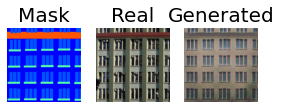

Epoch 2/20
75/75 [==============================] - 57s 710ms/step - ge_loss: 61.5508 - d_loss: 0.8456


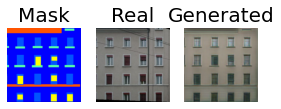

Epoch 3/20
75/75 [==============================] - 58s 721ms/step - ge_loss: 50.3885 - d_loss: 0.6842


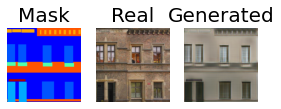

Epoch 4/20
75/75 [==============================] - 57s 717ms/step - ge_loss: 46.0137 - d_loss: 0.6352


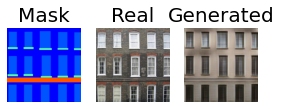

Epoch 5/20
75/75 [==============================] - 58s 727ms/step - ge_loss: 43.8572 - d_loss: 0.6114


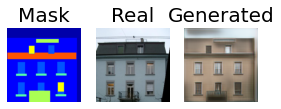

Epoch 6/20
75/75 [==============================] - 58s 730ms/step - ge_loss: 39.5849 - d_loss: 0.6030


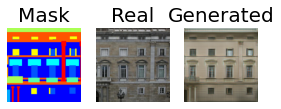

Epoch 7/20
75/75 [==============================] - 57s 721ms/step - ge_loss: 44.1746 - d_loss: 0.5683


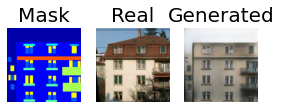

Epoch 8/20
75/75 [==============================] - 57s 719ms/step - ge_loss: 40.9016 - d_loss: 0.5553


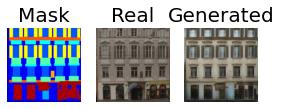

Epoch 9/20
75/75 [==============================] - 57s 718ms/step - ge_loss: 37.6365 - d_loss: 0.5395


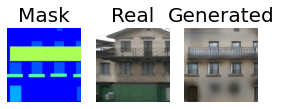

Epoch 10/20
75/75 [==============================] - 57s 717ms/step - ge_loss: 37.7665 - d_loss: 0.5777


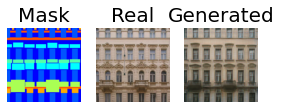

Epoch 11/20
75/75 [==============================] - 58s 726ms/step - ge_loss: 37.8204 - d_loss: 0.5552


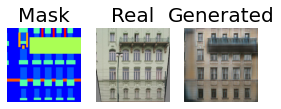

Epoch 12/20
75/75 [==============================] - 57s 719ms/step - ge_loss: 36.1721 - d_loss: 0.5639


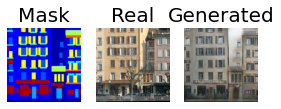

Epoch 13/20
75/75 [==============================] - 58s 728ms/step - ge_loss: 35.6387 - d_loss: 0.5565


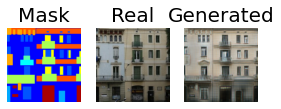

Epoch 14/20
75/75 [==============================] - 57s 720ms/step - ge_loss: 35.8427 - d_loss: 0.5391


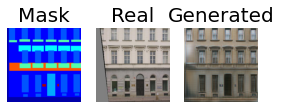

Epoch 15/20
75/75 [==============================] - 57s 719ms/step - ge_loss: 35.7612 - d_loss: 0.5514


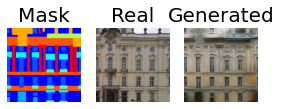

Epoch 16/20
75/75 [==============================] - 58s 728ms/step - ge_loss: 38.6049 - d_loss: 0.5373


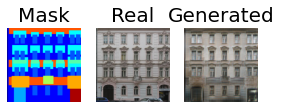

Epoch 17/20
75/75 [==============================] - 57s 720ms/step - ge_loss: 38.6489 - d_loss: 0.5580


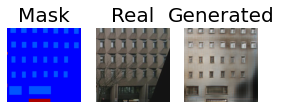

Epoch 18/20
75/75 [==============================] - 57s 719ms/step - ge_loss: 32.8560 - d_loss: 0.5561


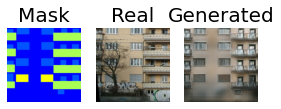

Epoch 19/20
75/75 [==============================] - 58s 727ms/step - ge_loss: 32.6446 - d_loss: 0.5443


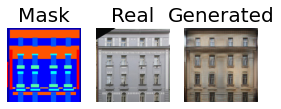

Epoch 20/20
75/75 [==============================] - 57s 721ms/step - ge_loss: 33.8674 - d_loss: 0.5159


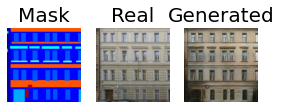

In [16]:
gaugan = GauGAN((IMG_WIDTH, IMG_HEIGHT, 3), N_CLASS, BATCH_SIZE)

ge_optimizer = Adam(1e-4, 0.0, 0.999)
d_optimizer = Adam(4e-4, 0.0, 0.999)
gaugan.compile(ge_optimizer, d_optimizer)

callbacks = [GenerativeCallback(test_dataset, 1)]

gaugan.fit(train_dataset, epochs=20, callbacks=callbacks)